# s1 backscatter for lake ice cover

In [1]:
# run this on planeatry computer [conda env: notebook]*
from dask.distributed import LocalCluster
import dask
import dask.dataframe as dd
import geopandas as gpd
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pystac
import pystac_client
import planetary_computer
import rioxarray as rio
import seaborn as sns
from shapely.geometry import LineString, Point, box, Polygon
import stackstac
from tqdm import tqdm
import xarray as xr
import utils
from geocube.api.core import make_geocube

In [2]:
centrelines = gpd.read_file('../data/streams_v3.geojson')

basins = (gpd.read_file('../data/basins/Greenland_Basins_PS_v1.4.2.shp')
          .dissolve('SUBREGION1'))
centrelines = centrelines.sjoin(basins.drop(columns=['NAME', 'GL_TYPE']),
                                how='left'
                                ).rename(columns={'index_right': 'region'})

lakes = gpd.read_file('../data/lake_areas.geojson')

lakes = lakes.sjoin_nearest(centrelines)
lakes = lakes.sort_values(by='id').drop(columns=['index_right', 'name', 'lake_land'])

In [3]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [42]:
medians = []
ids = []
for row in tqdm(lakes.to_crs(4326).itertuples()):
    
    search = catalog.search(collections=['sentinel-1-rtc'],
                            intersects=row.geometry)
    
    s1items = search.item_collection()
    
    # get most common projection
    vals, cnts = np.unique([item.properties['proj:epsg'] for item in s1items] ,return_counts=True)
    epsg = int(vals[np.argmax(cnts)])
    
    # stack & clip
    ds = stackstac.stack(planetary_computer.sign(s1items),
                        epsg=epsg,
                        bounds_latlon=row.geometry.bounds)
    
    mask = (make_geocube(lakes.to_crs(4326).loc[lakes['id']==row.id],
                          fill=np.nan,
                          like=ds)['id']
             .rename('mask'))
    
    # apply mask and convert to dB
    ds_db = xr.where(mask==row.id,
                     10 * np.log10(ds),
                     np.nan)

    median = (ds_db
              .median(dim=['y','x'], skipna=True)
              .rename('dB'))
    
    medians.append(median) # consider making this a future
    ids.append(row.id)

14it [00:40,  2.87s/it]


In [43]:
with LocalCluster() as cluster:
    client = cluster.get_client()
    print(client.dashboard_link)    
    computed_medians = dask.compute(*medians)
    dfs = []
    for m_ds, id in zip(computed_medians, ids):
        _df = m_ds.to_dataframe()
        _df['myid'] = id
        dfs.append(_df)
    
    df = pd.concat(dfs).reset_index().set_index('time')

http://127.0.0.1:8787/status


/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 28.47 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/s1759665/micromamba/envs/paper2/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarnin

In [44]:
df.to_parquet('../results/s1_lake_backscatter.parquet')

In [50]:
df = df.merge(centrelines['SUBREGION1'], left_on='myid', right_index=True)

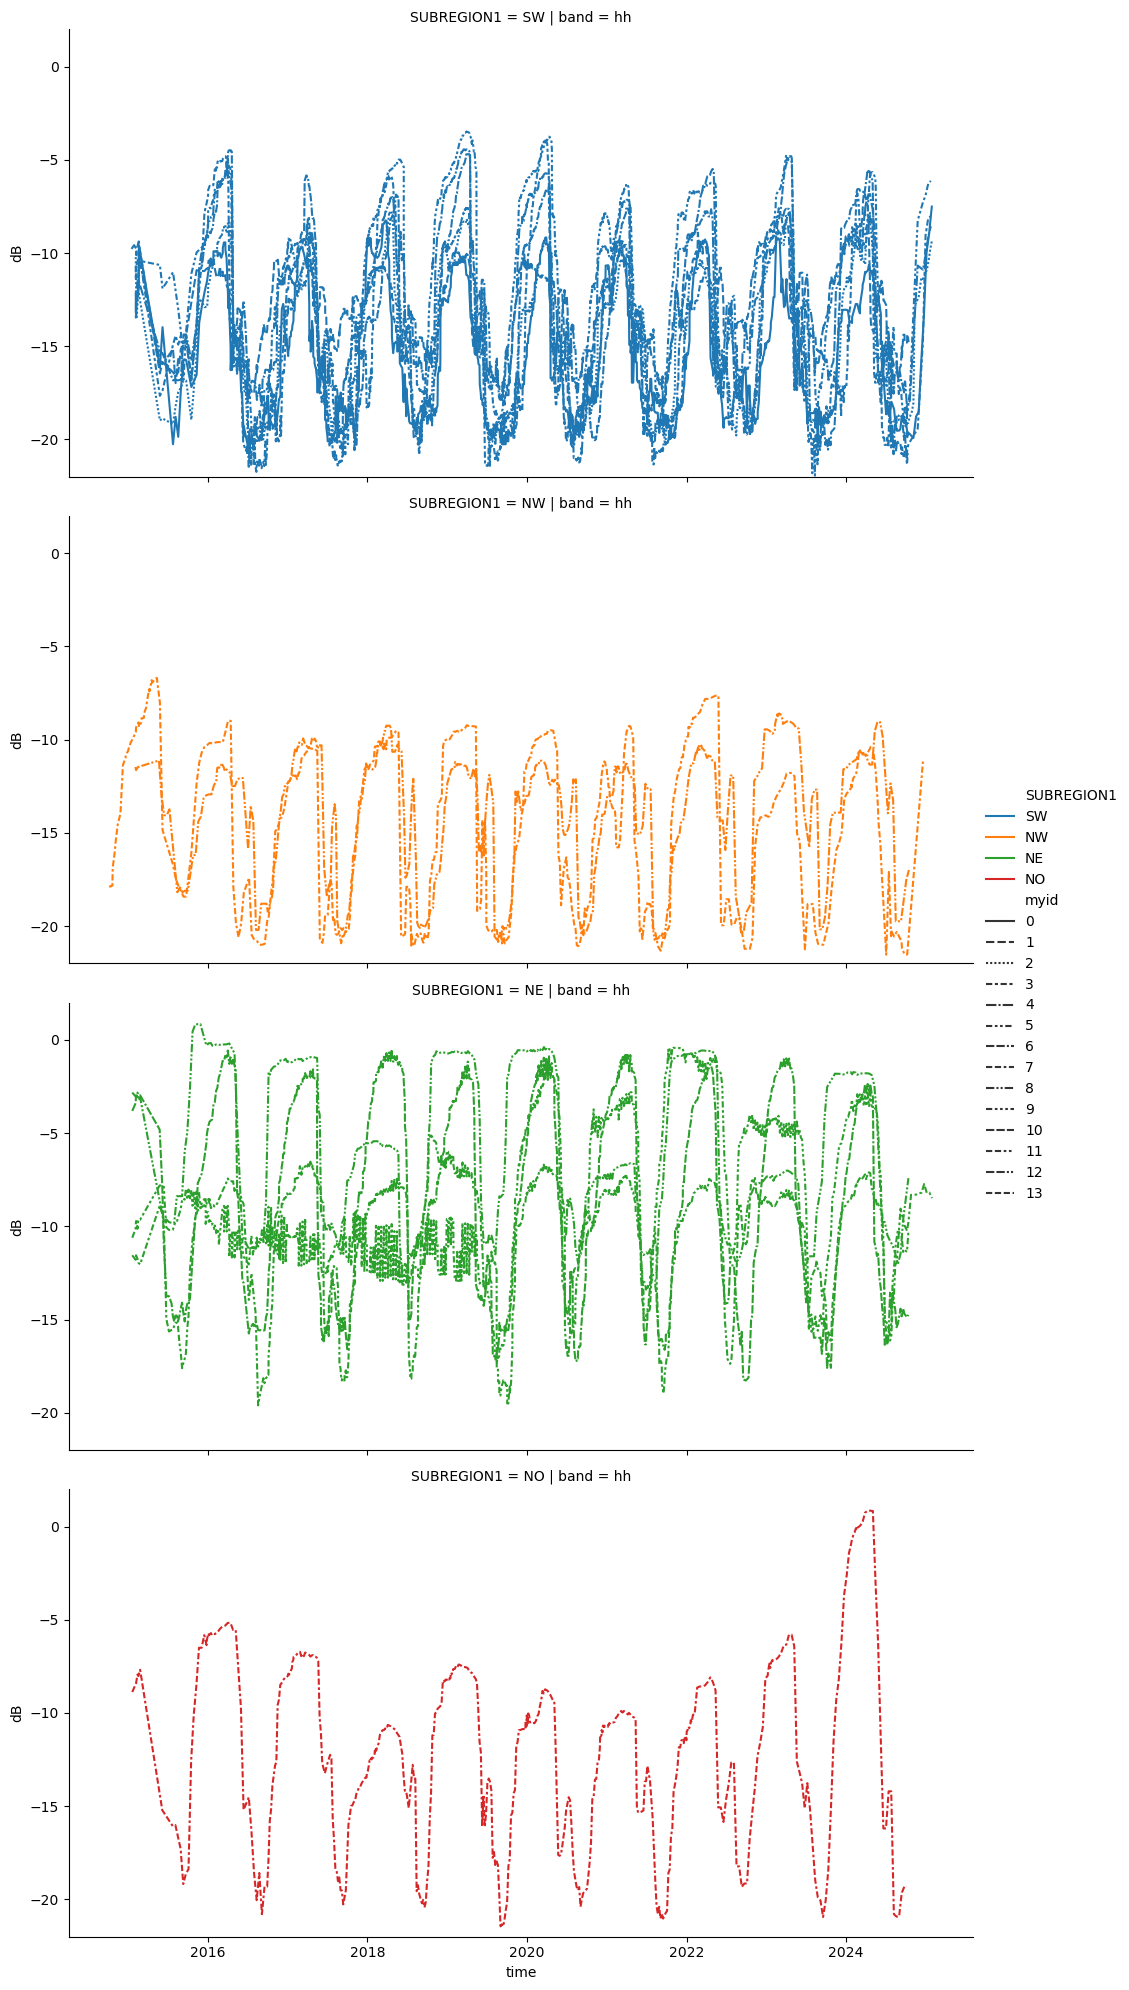

In [65]:
fg = sns.relplot(data=df.groupby(['myid', 'band', 'SUBREGION1'])['dB'].rolling('30d').median().reset_index(),
                 x='time',
                 y='dB',
                 row='SUBREGION1',
                 hue='SUBREGION1',
                 style='myid',
                 palette='tab10',
                 col='band',
                 col_order=['hh'],
                 kind='line',
                 aspect=2,
                #  height=10
                 )

fg.set(ylim=(-22,2))

In [78]:
df

,band,id,sar:instrument_mode,s1:orbit_source,sar:polarizations,sar:observation_direction,s1:total_slices,constellation,proj:epsg,sat:absolute_orbit,...,sat:orbit_state,sar:center_frequency,s1:processing_level,sar:resolution_range,start_datetime,title,description,raster:bands,epsg,dB
time,,,,,,,,,,,,,,,,,,,,,
2015-02-06 09:45:02.940033,hh,S1A_IW_GRDH_1SSH_20150206T094450_20150206T0945...,IW,RESORB,[HH],right,8,Sentinel-1,32622,4501,...,descending,5.405,1,20,2015-02-06 09:44:50.440288+00:00,"HH: horizontal transmit, horizontal receive",Terrain-corrected gamma naught values of signa...,"{'nodata': -32768, 'data_type': 'float32', 'sp...",32622,-11.787594
2015-02-06 09:45:02.940033,hv,S1A_IW_GRDH_1SSH_20150206T094450_20150206T0945...,IW,RESORB,[HH],right,8,Sentinel-1,32622,4501,...,descending,5.405,1,20,2015-02-06 09:44:50.440288+00:00,"HV: horizontal transmit, vertical receive",Terrain-corrected gamma naught values of signa...,"{'nodata': -32768, 'data_type': 'float32', 'sp...",32622,NaN
2015-02-06 21:02:01.694846,hh,S1A_IW_GRDH_1SSH_20150206T210149_20150206T2102...,IW,RESORB,[HH],right,20,Sentinel-1,32622,4508,...,ascending,5.405,1,20,2015-02-06 21:01:49.195524+00:00,"HH: horizontal transmit, horizontal receive",Terrain-corrected gamma naught values of signa...,"{'nodata': -32768, 'data_type': 'float32', 'sp...",32622,-12.805215
2015-02-06 21:02:01.694846,hv,S1A_IW_GRDH_1SSH_20150206T210149_20150206T2102...,IW,RESORB,[HH],right,20,Sentinel-1,32622,4508,...,ascending,5.405,1,20,2015-02-06 21:01:49.195524+00:00,"HV: horizontal transmit, vertical receive",Terrain-corrected gamma naught values of signa...,"{'nodata': -32768, 'data_type': 'float32', 'sp...",32622,NaN
2015-02-08 20:45:34.523514,hh,S1A_IW_GRDH_1SSH_20150208T204522_20150208T2045...,IW,RESORB,[HH],right,21,Sentinel-1,32622,4537,...,ascending,5.405,1,20,2015-02-08 20:45:22.024543+00:00,"HH: horizontal transmit, horizontal receive",Terrain-corrected gamma naught values of signa...,"{'nodata': -32768, 'data_type': 'float32', 'sp...",32622,-10.109395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-04 21:02:44.691152,hv,S1A_IW_GRDH_1SDH_20241004T210232_20241004T2102...,IW,PREORB,"[HH, HV]",right,15,Sentinel-1,32622,55958,...,ascending,5.405,1,20,2024-10-04 21:02:32.191560+00:00,"HV: horizontal transmit, vertical receive",Terrain-corrected gamma naught values of signa...,"{'nodata': -32768, 'data_type': 'float32', 'sp...",32622,-26.510515
2024-10-06 20:46:26.293429,hh,S1A_IW_GRDH_1SDH_20241006T204613_20241006T2046...,IW,RESORB,"[HH, HV]",right,17,Sentinel-1,32622,55987,...,ascending,5.405,1,20,2024-10-06 20:46:13.793579+00:00,"HH: horizontal transmit, horizontal receive",Terrain-corrected gamma naught values of signa...,"{'nodata': -32768, 'data_type': 'float32', 'sp...",32622,-19.307705
2024-10-06 20:46:26.293429,hv,S1A_IW_GRDH_1SDH_20241006T204613_20241006T2046...,IW,RESORB,"[HH, HV]",right,17,Sentinel-1,32622,55987,...,ascending,5.405,1,20,2024-10-06 20:46:13.793579+00:00,"HV: horizontal transmit, vertical receive",Terrain-corrected gamma naught values of signa...,"{'nodata': -32768, 'data_type': 'float32', 'sp...",32622,-22.420612


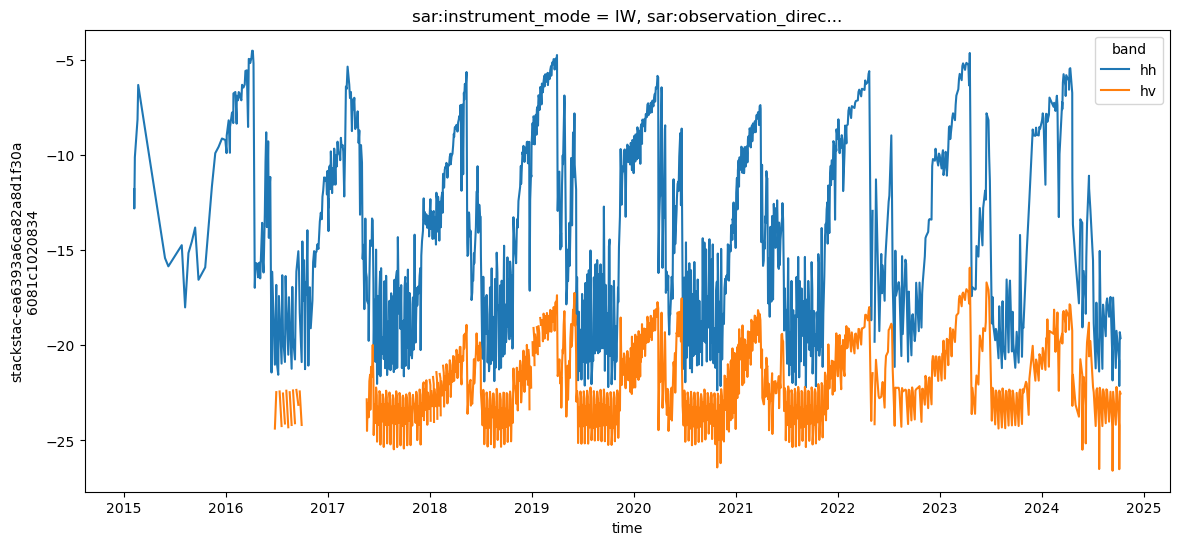

In [60]:
median.plot(hue='band', figsize=[14,6])